# Predicting Merchant Fraudulence for E-commerce Business

### Problem statment : 

Predict if the Merchant is Fraudster or not for an e-commerce client.

âXYZâ is a large e-commerce company with its operations in several countries. As the online giant grows, so has the number of fraudster merchants are. They deliver counterfeits or, in some cases, nothing at all. Such schemes leave customers duped, and place both legitimate merchants and the company itself in a constant battle to rid the marketplace of scammers. Determining this is also important in budgeting for fraud investigation. It's a well-known problem both to the company and to merchants, which they say hasn't effectively addressed the issue. They are serious about it and want to protect themselves from these fraudulent merchants using technology.

You are expected to create an analytical and modelling framework to predict the Merchant Fraudulency(yes/no) based on the quantitative and qualitative features provided in the dataset 

### Problem Understanding

1. Fraudulent Merchants 
2. Merchant sell counterfeit product or donât dispatch items
3. Company brand value impacted.
4. Company make loss on refund to customers


### Expectation 

1. Budget required for fraud detection
2. To protect client from fraudulent merchants using clientâs technology
3. Build analytical framework to predict Merchant fraudulency
4. Give possible insights from the data about fraudulent merchant

# Loading required Libriaries

In [1]:
#Interface with Operating system to run Python
import os

#Import numerical and pandas libraries
import numpy as np
import pandas as pd


#For plotting - Matplot
import matplotlib.pyplot as plt
%matplotlib notebook

#For plotting - Seaborn
import seaborn as sns

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [58]:
#Preprocessing libraries

from sklearn import preprocessing

#For imputing 
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

#To dummify
from sklearn.preprocessing import OneHotEncoder

#To standardize
from sklearn.preprocessing import StandardScaler

#To normalize
from sklearn.preprocessing import MinMaxScaler

#To do Train_test split
from sklearn.model_selection import train_test_split

#To do GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold


#To check performance metrics
from sklearn.metrics import accuracy_score

#To create confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [3]:
from sklearn.compose import ColumnTransformer

## Read the Data set

In [4]:
from azureml import Workspace

ws = Workspace()

#Train Merchant data
ds1 = ws.datasets['train_merchant_data.csv']
train_merchant = ds1.to_dataframe()

#Test Merchant data 
ds2 = ws.datasets['test_merchant_data.csv']
test_merchant = ds2.to_dataframe()

#Train order data
ds3 = ws.datasets['train_order_data.csv']
train_order = ds3.to_dataframe()

#Test order data
ds4 = ws.datasets['test_order_data.csv']
test_order = ds4.to_dataframe()

#IP boundry details 
ds5 = ws.datasets['ip_boundaries_countries.csv']
ip_details = ds5.to_dataframe()

#Train Target data
ds6 = ws.datasets['train.csv']
train_target = ds6.to_dataframe()

#Test Target data
ds7 = ws.datasets['test.csv']
test_target = ds7.to_dataframe()


### Data cleaning and Merging

In [5]:
#Combining train dataset
train_data = pd.merge(train_merchant, train_order, on='Merchant_ID', how='outer')

In [6]:
#combing unseen dataset
Unseen_data = pd.merge(test_merchant, test_order, on='Merchant_ID', how='outer')

In [7]:
#Combining train dataset
train_final_data = pd.merge(train_data, train_target, on='Merchant_ID', how='outer')

In [8]:
#combing unseen dataset
unseen_final_data = pd.merge(Unseen_data, test_target, on='Merchant_ID', how='outer')

## Feature Engineering

In [9]:
#Define a function to convert IP address to Integer.

def ip_to_int(ip_ser):
    ips = ip_ser.str.split('.', expand=True).astype(np.int16).values
    mults = np.tile(np.array([24, 16, 8, 0]), len(ip_ser)).reshape(ips.shape)
    return np.sum(np.left_shift(ips, mults), axis=1)

In [10]:
#Appling on Train data set

train_final_data['_ip'] = ip_to_int(train_final_data.IP_Address)
ip_details[['_ip_range_start','_ip_range_end']] = ip_details.filter(like='ip_address').apply(lambda x: ip_to_int(x))

In [11]:
#Appling on Test data set

unseen_final_data['_ip'] = ip_to_int(unseen_final_data.IP_Address)
ip_details[['_ip_range_start','_ip_range_end']] = ip_details.filter(like='ip_address').apply(lambda x: ip_to_int(x))

In [12]:
#Appling on Train data set
train_final_data['x'] = (train_final_data._ip.apply(lambda x: ip_details.query('_ip_range_start <= @x <= _ip_range_end')
                         .index
                         .values)
              .apply(lambda x: x[0] if len(x) else -1))

In [13]:
#Appling on Test data set
unseen_final_data['x'] = (unseen_final_data._ip.apply(lambda x: ip_details.query('_ip_range_start <= @x <= _ip_range_end')
                         .index
                         .values)
              .apply(lambda x: x[0] if len(x) else -1))

In [14]:
#Merging Train Data set to bring Country column

train_data=(pd.merge(train_final_data.drop('_ip',1),
          ip_details.filter(regex=r'^((?!.?ip_range_).*)$'),
          left_on='x',
          right_index=True,
          how='left').drop('x',1))

In [15]:
#Merging Unseen Data set to bring Country column

unseen_data=(pd.merge(unseen_final_data.drop('_ip',1),
          ip_details.filter(regex=r'^((?!.?ip_range_).*)$'),
          left_on='x',
          right_index=True,
          how='left').drop('x',1))

In [16]:
#To view the data after getting country details
train_data.head(3)

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster,lower_bound_ip_address,upper_bound_ip_address,country
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0,48.0.0.0,48.255.255.255,United States
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0,94.0.0.0,94.15.255.255,United Kingdom
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0,58.92.0.0,58.95.255.255,Japan


In [17]:
#To get list of columns
train_data.columns

Index(['Ecommerce_Provider_ID', 'Merchant_ID', 'Merchant_Registration_Date',
       'Registered_Device_ID', 'Gender', 'Age', 'IP_Address', 'Customer_ID',
       'Order_ID', 'Date_of_Order', 'Order_Value_USD', 'Order_Source',
       'Order_Payment_Method', 'Fraudster', 'lower_bound_ip_address',
       'upper_bound_ip_address', 'country'],
      dtype='object')

In [18]:
#To view data types of each columns
train_data.dtypes

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
lower_bound_ip_address        object
upper_bound_ip_address        object
country                       object
dtype: object

In [19]:
#To view shape of the data
train_data.shape

(54213, 17)

In [20]:
#To view summary of the data
train_data.describe(include='all')

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster,lower_bound_ip_address,upper_bound_ip_address,country
count,54213.0,54213.000000,54213,54213,54213,54213.000000,54213,54213.000000,54213,54213,54213.000000,54213,54213,54213.00000,46402,46402,46402
unique,NaN,NaN,54213,51291,2,NaN,52028,NaN,54213,54161,NaN,3,5,NaN,14914,14914,109
top,NaN,NaN,2018-06-18 01:50:41,RDLIARTBSYNJX,M,NaN,115.241.135.193,NaN,43658f7b57f4,2018-05-21 05:58:13,NaN,SEO,Credit Card,NaN,12.0.0.0,12.255.255.255,United States
freq,NaN,NaN,1,9,31761,NaN,9,NaN,1,2,NaN,21884,21844,NaN,262,262,20963
mean,1746213.0,200395.176212,NaN,NaN,NaN,33.122240,NaN,137966.285208,NaN,NaN,92.230240,NaN,NaN,0.09269,NaN,NaN,NaN
std,0.0,115398.486895,NaN,NaN,NaN,8.630091,NaN,15563.516156,NaN,NaN,45.673263,NaN,NaN,0.29000,NaN,NaN,NaN
min,1746213.0,2.000000,NaN,NaN,NaN,18.000000,NaN,111234.000000,NaN,NaN,22.000000,NaN,NaN,0.00000,NaN,NaN,NaN
25%,1746213.0,100997.000000,NaN,NaN,NaN,27.000000,NaN,124471.000000,NaN,NaN,55.000000,NaN,NaN,0.00000,NaN,NaN,NaN
50%,1746213.0,200574.000000,NaN,NaN,NaN,32.000000,NaN,137864.000000,NaN,NaN,88.000000,NaN,NaN,0.00000,NaN,NaN,NaN
75%,1746213.0,300407.000000,NaN,NaN,NaN,39.000000,NaN,151405.000000,NaN,NaN,122.000000,NaN,NaN,0.00000,NaN,NaN,NaN


In [21]:
#To view null value details
train_data.isnull().sum()

Ecommerce_Provider_ID            0
Merchant_ID                      0
Merchant_Registration_Date       0
Registered_Device_ID             0
Gender                           0
Age                              0
IP_Address                       0
Customer_ID                      0
Order_ID                         0
Date_of_Order                    0
Order_Value_USD                  0
Order_Source                     0
Order_Payment_Method             0
Fraudster                        0
lower_bound_ip_address        7811
upper_bound_ip_address        7811
country                       7811
dtype: int64

## Data Visualization

In [154]:
## Define a function to view bar chargs
def bar_chart(feature):
    fraud = train_data[train_data['Fraudster']==1][feature].value_counts()
    good = train_data[train_data['Fraudster']==0][feature].value_counts()
    df = pd.DataFrame([fraud,good])
    df.index = ['Fraud','Good']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

<IPython.core.display.Javascript object>


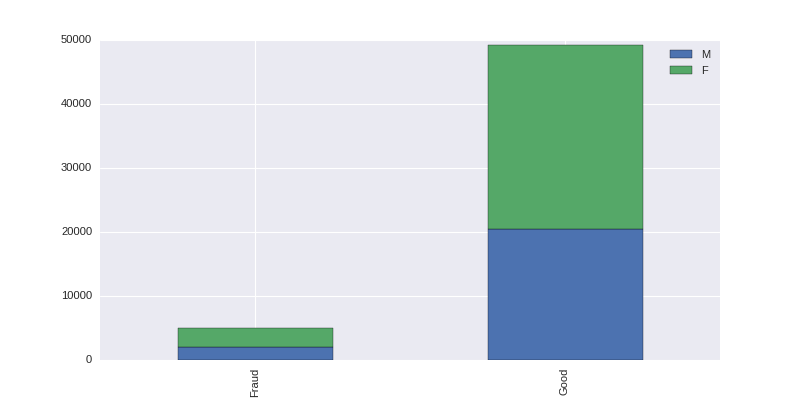

In [155]:
bar_chart('Gender')

<IPython.core.display.Javascript object>


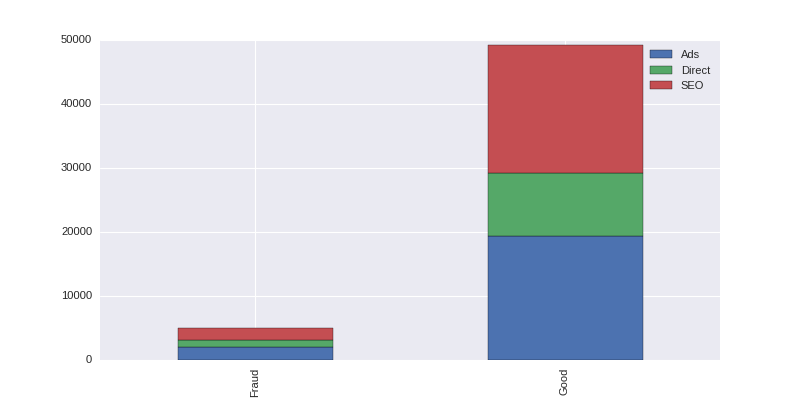

In [163]:
bar_chart('Order_Source')

<IPython.core.display.Javascript object>


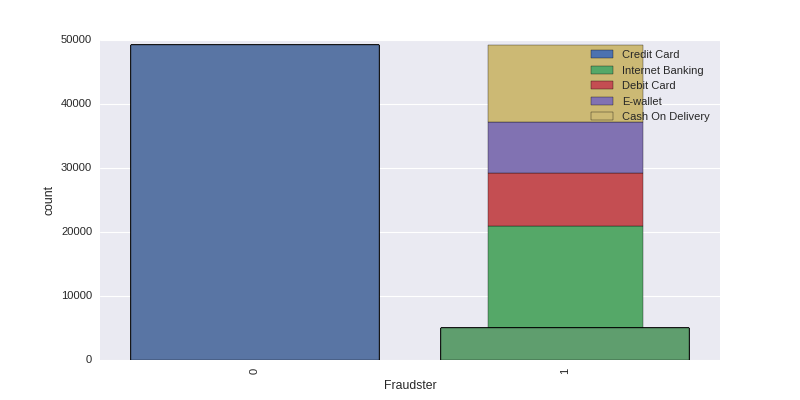

In [173]:
bar_chart('Order_Payment_Method')

In [203]:
sns.countplot(x="Order_Payment_Method", data=train_data[train_data.Fraudster == 1])
plt.show()

In [204]:
# Plot Distribution
sns.countplot(x='Fraudster', data=train_data)
plt.show()

# What are the counts?
train_data.Fraudster.value_counts()
# What is the percentage?
count_0= len(train_data[train_data.Fraudster == 0])
count_1 = len(train_data[train_data.Fraudster != 0])

percent_success = (count_1/(count_0+ count_1))*100

print('Percentage of Fraudlent marchent :', percent_success, "%")

Percentage of Fraudlent marchent : 9.268994521609208 %


## High Fraudulent countries

In [195]:
Fraud_ratio_country = train_data[train_data.Fraudster == 1].country.value_counts()/train_data.country.value_counts()

In [196]:
Fraud_ratio_country.sort_values(ascending=False)

Turkmenistan                  1.000000
Uzbekistan                    0.666667
Namibia                       0.600000
Sri Lanka                     0.545455
Luxembourg                    0.391304
Honduras                      0.333333
Tunisia                       0.306122
Bolivia                       0.277778
Kuwait                        0.258065
Lithuania                     0.225806
United Arab Emirates          0.191489
New Zealand                   0.190909
Greece                        0.188889
Seychelles                    0.187500
Paraguay                      0.181818
Ireland                       0.181818
Bangladesh                    0.166667
Angola                        0.166667
Peru                          0.163265
Ecuador                       0.156250
Denmark                       0.152439
Venezuela                     0.142857
Chile                         0.139073
Saudi Arabia                  0.138614
Kazakhstan                    0.137931
Mexico                   

In [197]:
##To get percentage of Fraudster country wise
train_data[train_data.Fraudster == 1].country.value_counts(normalize=True)

United States                      0.451983
China                              0.087554
Japan                              0.060509
United Kingdom                     0.037360
Korea Republic of                  0.031630
Canada                             0.028192
France                             0.025670
Germany                            0.021545
Brazil                             0.021545
India                              0.013752
Mexico                             0.012835
Russian Federation                 0.012148
Italy                              0.011918
Netherlands                        0.010772
Australia                          0.010314
Sweden                             0.009168
Taiwan; Republic of China (ROC)    0.008939
South Africa                       0.008022
Norway                             0.005959
Spain                              0.005959
Denmark                            0.005730
Argentina                          0.005042
Switzerland                     

In [199]:
sns.countplot(x="country", data=[train_data.Fraudster == 1])
plt.show()

AttributeError: 'list' object has no attribute 'get'

In [201]:
#To check for possibility of Fraudster - gets registered from particular device. 
train_data[train_data.Fraudster ==1].Registered_Device_ID.value_counts()

RDLIARTBSYNJX    9
VIPZYJGMVMXOF    9
EJMPKMGDHBEDY    8
ETONJQAENXSZD    8
AZPFJFPBMDWHC    8
RJEAMRBBMPWEA    8
USYRYIUTYSOKD    8
BNMPEZLFOYNSM    8
VGGTRBYDZMCPN    8
EKRFGOOSEMDPD    8
KJEKRMHEHLUOR    8
DEQPIMGWUAEXZ    8
WXIQKYAAYEKPM    8
TCFHYPEGJMBIZ    8
QGWUOPUHKKOWQ    8
ZWNEVHJOVDGKD    8
WTLHOACWUKSRU    7
KUHLMLHZIACKS    7
HYTGEOUKFGBRI    7
ATDPXVNQZMBEY    7
WIMZUSGLJHWOR    7
DIZIGMBVWQXAE    7
VGHZWPXJRLAQQ    7
BTOAUDUQMYTSM    7
EKDMTSGQNQUUD    7
CHLPJUDZTWXES    7
WFAFTLJEJJUBV    7
XTKBQWWVJFWWR    7
CDNCKTZZGWNXT    7
IYARYWRSXULAE    7
                ..
QYZBFTZMUFLLX    0
QYYMAKOWIFKCO    0
QYYFXJDSEGZIG    0
QYYBSFBKQEDLB    0
QYXNJGADWHMLD    0
QZEWSJKNGPXAR    0
QZFZHRWCSAVHE    0
QZMPWGRACNPRG    0
QZHWTKVDIRFNM    0
QZMMOILZMXXLO    0
QZLQGREUUSHGF    0
QZKSKFODGIRAS    0
QZKBQHMTVFEUF    0
QZJZSGKWDJKHR    0
QZJZRQBGBXWMD    0
QZJQSTDUXMENS    0
QZIJJPRVUDRLA    0
QZIIDYDQDMXPI    0
QZHTJNEOCZFSD    0
QZGIDWWXZUTSR    0
QZHTEDXVVDSAJ    0
QZHPVTCYOTMO

### Dropping Unneccessary columns

In [22]:
#Dropping unneccesssary columns - Train Data
unnecessary_col =['Ecommerce_Provider_ID', 'Customer_ID', 'lower_bound_ip_address', 'upper_bound_ip_address']
train_data.drop(unnecessary_col, axis=1, inplace=True)

In [23]:
#Dropping unneccesssary columns - Unseen Data
unnecessary_col =['Ecommerce_Provider_ID', 'Customer_ID', 'lower_bound_ip_address', 'upper_bound_ip_address']
unseen_data.drop(unnecessary_col, axis=1, inplace=True)

In [25]:
#Dropping order_id column
train_data = train_data.drop('Order_ID', axis=1)

In [26]:
#Dropping order_id column - Not giving any significance. 
unseen_data = unseen_data.drop('Order_ID', axis=1)

In [27]:
#To view data types of each columns
train_data.dtypes

Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
country                       object
dtype: object

In [28]:
#Converting to correct categorical columns - Train data set

for col in ['Gender','Fraudster', 'Order_Source', 'Order_Payment_Method', 'Merchant_ID', 'Registered_Device_ID', 'IP_Address', 'country']:
    train_data[col] = train_data[col].astype('category')

In [29]:
#Converting to correct categorical columns - Unseen data set

for col in ['Gender', 'Order_Source', 'Order_Payment_Method', 'Merchant_ID', 'Registered_Device_ID', 'IP_Address', 'country']:
    unseen_data[col] = unseen_data[col].astype('category')

In [30]:
#To view data types of each columns after type conversion
train_data.dtypes

Merchant_ID                   category
Merchant_Registration_Date      object
Registered_Device_ID          category
Gender                        category
Age                              int64
IP_Address                    category
Date_of_Order                   object
Order_Value_USD                  int64
Order_Source                  category
Order_Payment_Method          category
Fraudster                     category
country                       category
dtype: object

In [31]:
#Converting to correct Date columns - Train Data set
train_data[['Merchant_Registration_Date','Date_of_Order']] = train_data[['Merchant_Registration_Date','Date_of_Order']].apply(pd.to_datetime)

In [32]:
#Converting to correct Date columns - Unseen Data set
unseen_data[['Merchant_Registration_Date','Date_of_Order']] = unseen_data[['Merchant_Registration_Date','Date_of_Order']].apply(pd.to_datetime)

In [33]:
for col in ['Merchant_Registration_Date', 'Date_of_Order']:
    train_data[col] = train_data[col].astype('category')

In [34]:
for col in ['Merchant_Registration_Date', 'Date_of_Order']:
    unseen_data[col] = unseen_data[col].astype('category')

In [35]:
#To view list of columns in Train data
train_data.columns

Index(['Merchant_ID', 'Merchant_Registration_Date', 'Registered_Device_ID',
       'Gender', 'Age', 'IP_Address', 'Date_of_Order', 'Order_Value_USD',
       'Order_Source', 'Order_Payment_Method', 'Fraudster', 'country'],
      dtype='object')

In [51]:
#Splitting data as Categorical and numerical columns/Attributes
cat_attr = ['Merchant_ID','Registered_Device_ID', 'Gender', 'IP_Address', 'Order_Source', 'Order_Payment_Method', 'Fraudster', 'country'] 
num_attr = ['Merchant_Registration_Date','Age', 'Date_of_Order', 'Order_Value_USD']


In [65]:
#To remove traget attribute
cat_attr.remove('Fraudster')

### Pipeline

In [66]:
# Numerical Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categorical Pipeline 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [160]:
#Model building libraries

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans

In [121]:
!pip install xgboost

    100% |ââââââââââââââââââââââââââââââââ| 142.8MB 7.2kB/s eta 0:00:01   35% |ââââââââââââ                    | 50.3MB 28.6MB/s eta 0:00:04    37% |ââââââââââââ                    | 53.9MB 18.6MB/s eta 0:00:05ï¿½ï¿½ââ            | 87.8MB 30.4MB/s eta 0:00:02ââââââââââââââââ           | 90.1MB 28.2MB/s eta 0:00:02
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [122]:
from xgboost import XGBClassifier

## Train Test split

In [69]:
X, y = train_data.loc[:,train_data.columns!='Fraudster'], train_data.loc[:,'Fraudster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) 

## Base Model Building

In [157]:
#Building Logistic regression
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(C=c))
                        ])
    lr.fit(X_train, y_train)
    print ("Train Accuracy for C=%s: %s"
           % (c, accuracy_score(y_train, lr.predict(X_train))))
    print ("Accuracy for C=%s: %s"
           % (c, accuracy_score(y_test, lr.predict(X_test))))
    print ("Train F1 for C=%s: %s"
           % (c, f1_score(y_train, lr.predict(X_train),average='weighted')))
    print ("Test F1 for C=%s: %s"
           % (c, f1_score(y_test, lr.predict(X_test),average='weighted')))
    print("--------------------------------------------------------------")

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Accuracy for C=0.01: 0.9069277187804685
Accuracy for C=0.01: 0.9082021642892277


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train F1 for C=0.01: 0.8626628885738437
Test F1 for C=0.01: 0.8645113045733
--------------------------------------------------------------


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Accuracy for C=0.05: 0.9129621333895491
Accuracy for C=0.05: 0.9105386128873586
Train F1 for C=0.05: 0.8767354065906832
Test F1 for C=0.05: 0.8701280447893367
--------------------------------------------------------------


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Accuracy for C=0.25: 0.94561121505178
Accuracy for C=0.25: 0.927201180521397
Train F1 for C=0.25: 0.935191676796684
Test F1 for C=0.25: 0.9048809780808765
--------------------------------------------------------------


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Accuracy for C=0.5: 0.9522253550818204
Accuracy for C=0.5: 0.9368544023610428
Train F1 for C=0.5: 0.9446139955213199
Test F1 for C=0.5: 0.921783363509087
--------------------------------------------------------------


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train Accuracy for C=1: 0.9567314026720072
Accuracy for C=1: 0.9418347270044269
Train F1 for C=1: 0.9507032960300249
Test F1 for C=1: 0.930032374406661
--------------------------------------------------------------


In [159]:
## Predict
train_predictions = lr.predict(X_train)
test_predictions = lr.predict(X_test)


### Train data accuracy
from sklearn.metrics import accuracy_score,f1_score

print("TRAIN Conf Matrix : \n", confusion_matrix(y_train, train_predictions))
print("\nTRAIN DATA ACCURACY",accuracy_score(y_train,train_predictions))
print("\nTrain data f1-score for class '0'",f1_score(y_train,train_predictions,pos_label=0))
print("\nTrain data f1-score for class '1'",f1_score(y_train,train_predictions,pos_label=1))

### Test data accuracy
print("\n\n--------------------------------------\n\n")

print("TEST Conf Matrix : \n", confusion_matrix(y_test, test_predictions))
print("\nTEST DATA ACCURACY",accuracy_score(y_test,test_predictions))
print("\nTest data f1-score for class '0'",f1_score(y_test,test_predictions,pos_label=0))
print("\nTest data f1-score for class '1'",f1_score(y_test,test_predictions,pos_label=1))

TRAIN Conf Matrix : 
 [[34415     2]
 [ 1640  1892]]

TRAIN DATA ACCURACY 0.9567314026720072

Train data f1-score for class '0' 0.976699965943921

Train data f1-score for class '1' 0.6973829708809437


--------------------------------------


TEST Conf Matrix : 
 [[14751    20]
 [  926   567]]

TEST DATA ACCURACY 0.9418347270044269

Test data f1-score for class '0' 0.9689306358381503

Test data f1-score for class '1' 0.5451923076923076


In [130]:
## F1 Score for weighted average
from sklearn.metrics import f1_score

f1_Train_lr = f1_score(y_true=y_train, y_pred = train_predictions, average='weighted')

f1_Test_lr = f1_score(y_true=y_test, y_pred = test_predictions, average='weighted')

print(f1_Train_lr)
print(f1_Test_lr)

0.9507032960300249
0.930032374406661


## Linear SVM

In [161]:
#Building Logistic regression
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lsvc = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LinearSVC(C=c))
                        ])
    lsvc.fit(X_train, y_train)
    print ("Train Accuracy for C=%s: %s"
           % (c, accuracy_score(y_train, lsvc.predict(X_train))))
    print ("Accuracy for C=%s: %s"
           % (c, accuracy_score(y_test, lsvc.predict(X_test))))
    print ("Train F1 for C=%s: %s"
           % (c, f1_score(y_train, lsvc.predict(X_train),average='weighted')))
    print ("Test F1 for C=%s: %s"
           % (c, f1_score(y_test, lsvc.predict(X_test),average='weighted')))
    print("--------------------------------------------------------------")

Train Accuracy for C=0.01: 0.9071385280244538
Accuracy for C=0.01: 0.9082021642892277
Train F1 for C=0.01: 0.8631789314471252
Test F1 for C=0.01: 0.8645113045733
--------------------------------------------------------------


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train Accuracy for C=0.05: 0.9481672771351024
Accuracy for C=0.05: 0.9268937530742745
Train F1 for C=0.05: 0.9388991962190083
Test F1 for C=0.05: 0.9047680139433787
--------------------------------------------------------------
Train Accuracy for C=0.25: 0.9999736488445018
Accuracy for C=0.25: 0.9473684210526315
Train F1 for C=0.25: 0.9999736505179966
Test F1 for C=0.25: 0.9392228323764092
--------------------------------------------------------------
Train Accuracy for C=0.5: 1.0
Accuracy for C=0.5: 0.9468765371372356
Train F1 for C=0.5: 1.0
Test F1 for C=0.5: 0.9388039145308565
--------------------------------------------------------------
Train Accuracy for C=1: 1.0
Accuracy for C=1: 0.9466920806689622
Train F1 for C=1: 1.0
Test F1 for C=1: 0.9386360361580804
--------------------------------------------------------------


In [162]:
## Predict
svc_train_predictions = lsvc.predict(X_train)
svc_test_predictions = lsvc.predict(X_test)


### Train data accuracy
from sklearn.metrics import accuracy_score,f1_score

print("TRAIN Conf Matrix : \n", confusion_matrix(y_train, svc_train_predictions))
print("\nTRAIN DATA ACCURACY",accuracy_score(y_train,svc_train_predictions))
print("\nTrain data f1-score for class '0'",f1_score(y_train,svc_train_predictions,pos_label=0))
print("\nTrain data f1-score for class '1'",f1_score(y_train,svc_train_predictions,pos_label=1))

### Test data accuracy
print("\n\n--------------------------------------\n\n")

print("TEST Conf Matrix : \n", confusion_matrix(y_test, svc_test_predictions))
print("\nTEST DATA ACCURACY",accuracy_score(y_test,svc_test_predictions))
print("\nTest data f1-score for class '0'",f1_score(y_test,svc_test_predictions,pos_label=0))
print("\nTest data f1-score for class '1'",f1_score(y_test,svc_test_predictions,pos_label=1))

TRAIN Conf Matrix : 
 [[34417     0]
 [    0  3532]]

TRAIN DATA ACCURACY 1.0

Train data f1-score for class '0' 1.0

Train data f1-score for class '1' 1.0


--------------------------------------


TEST Conf Matrix : 
 [[14705    66]
 [  801   692]]

TEST DATA ACCURACY 0.9466920806689622

Test data f1-score for class '0' 0.9713644020213364

Test data f1-score for class '1' 0.6148378498445136


## Gradient Boosting Model building

In [106]:
for 
GBM = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('GBM',GradientBoostingClassifier())])

In [107]:
GBM.fit(X_train, y_train)

## Predict
gbm_train_predictions = GBM.predict(X_train)
gbm_test_predictions = GBM.predict(X_test)


In [131]:


### Train data accuracy
from sklearn.metrics import accuracy_score,f1_score

print("TRAIN Conf Matrix : \n", confusion_matrix(y_train, gbm_train_predictions))
print("\nTRAIN DATA ACCURACY",accuracy_score(y_train,gbm_train_predictions))

### Test data accuracy
print("\n\n--------------------------------------\n\n")

print("TEST Conf Matrix : \n", confusion_matrix(y_test, gbm_test_predictions))
print("\nTEST DATA ACCURACY",accuracy_score(y_test,gbm_test_predictions))

TRAIN Conf Matrix : 
 [[34360    57]
 [ 1687  1845]]

TRAIN DATA ACCURACY 0.954043584811194


--------------------------------------


TEST Conf Matrix : 
 [[14742    29]
 [  686   807]]

TEST DATA ACCURACY 0.9560378750614855


In [132]:
## F1 Score for weighted average
from sklearn.metrics import f1_score

f1_Train_gbm = f1_score(y_true=y_train, y_pred = gbm_train_predictions, average='weighted')

f1_Test_gbm = f1_score(y_true=y_test, y_pred = gbm_test_predictions, average='weighted') 

print(f1_Train_gbm)
print(f1_Test_gbm)

0.9476825088745581
0.9503153333339633


### Random Forest Model

In [112]:
RF = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('RF',RandomForestClassifier())])

In [113]:
RF.fit(X_train, y_train)

## Predict
rf_train_predictions = RF.predict(X_train)
rf_test_predictions = RF.predict(X_test)

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [133]:
### Train data accuracy
from sklearn.metrics import accuracy_score,f1_score

print("TRAIN Conf Matrix : \n", confusion_matrix(y_train, rf_train_predictions))
print("\nTRAIN DATA ACCURACY",accuracy_score(y_train,rf_train_predictions))

### Test data accuracy
print("\n\n--------------------------------------\n\n")

print("TEST Conf Matrix : \n", confusion_matrix(y_test, rf_test_predictions))
print("\nTEST DATA ACCURACY",accuracy_score(y_test,rf_test_predictions))


TRAIN Conf Matrix : 
 [[34417     0]
 [  490  3042]]

TRAIN DATA ACCURACY 0.9870879338058974


--------------------------------------


TEST Conf Matrix : 
 [[14717    54]
 [  689   804]]

TEST DATA ACCURACY 0.9543162813575996


In [138]:
## F1 Score for weighted average
from sklearn.metrics import f1_score

f1_Train_rf = f1_score(y_true=y_train, y_pred = gbm_train_predictions, average='weighted')

f1_Test_rf = f1_score(y_true=y_test, y_pred = gbm_test_predictions, average='weighted') 

print(f1_Train_rf)
print(f1_Test_rf)

0.9476825088745581
0.9503153333339633


## XG Boost Model

In [165]:
xgb = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('XG', XGBClassifier())])

In [167]:
xgb_class = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('XG', XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.2))])
xgb_class = xgb_class.fit(X_train, y_train)

print ("Train Accuracy for C=%s: %s"
      % (c, accuracy_score(y_train, xgb_class.predict(X_train))))
print ("Accuracy for C=%s: %s"
      % (c, accuracy_score(y_test, xgb_class.predict(X_test))))
print ("Train F1 for C=%s: %s"
      % (c, f1_score(y_train, xgb_class.predict(X_train),average='weighted')))
print ("Test F1 for C=%s: %s"
      % (c, f1_score(y_test, xgb_class.predict(X_test),average='weighted')))
print("--------------------------------------------------------------")


Train Accuracy for C=1: 0.9548604706316371
Accuracy for C=1: 0.9564067879980325
Train F1 for C=1: 0.9484641142609331
Test F1 for C=1: 0.9506643240767796
--------------------------------------------------------------


In [168]:
## Predict
xg_train_predictions = XG.predict(X_train)
xg_test_predictions = XG.predict(X_test)

### Train data accuracy
from sklearn.metrics import accuracy_score,f1_score

print("TRAIN Conf Matrix : \n", confusion_matrix(y_train, xg_train_predictions))
print("\n TRAIN DATA ACCURACY",accuracy_score(y_train,xg_train_predictions))
print("\nTrain data f1-score for class '0'",f1_score(y_train,xg_train_predictions,pos_label=0))
print("\nTrain data f1-score for class '1'",f1_score(y_train,xg_train_predictions,pos_label=1))

### Test data accuracy
print("\n\n--------------------------------------\n\n")

print("TEST Conf Matrix : \n", confusion_matrix(y_test, xg_test_predictions))
print("\nTEST DATA ACCURACY",accuracy_score(y_test,xg_test_predictions))
print("\nTest data f1-score for class '0'",f1_score(y_test,xg_test_predictions,pos_label=0))
print("\nTest data f1-score for class '1'",f1_score(y_test,xg_test_predictions,pos_label=1))


TRAIN Conf Matrix : 
 [[34379    38]
 [ 1689  1843]]

 TRAIN DATA ACCURACY 0.9544915544546628

Train data f1-score for class '0' 0.975498332978648

Train data f1-score for class '1' 0.6809532606687605


--------------------------------------


TEST Conf Matrix : 
 [[14749    22]
 [  686   807]]

TEST DATA ACCURACY 0.956468273487457

Test data f1-score for class '0' 0.9765609481559955

Test data f1-score for class '1' 0.6950904392764858


In [137]:
## F1 Score for weighted average
from sklearn.metrics import f1_score

f1_Train_XG = f1_score(y_true=y_train, y_pred = gbm_train_predictions, average='weighted')

f1_Test_XG = f1_score(y_true=y_test, y_pred = gbm_test_predictions, average='weighted') 

print(f1_Train_XG)
print(f1_Test_XG)

0.9476825088745581
0.9503153333339633


In [186]:
!pip install -U imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/eb/aa/eba717a14df36f0b6f000ebfaf24c3189cd7987130f66cc3513efead8c2a/imbalanced_learn-0.6.1-py3-none-any.whl
Requirement already up-to-date: numpy>=1.11 in /home/nbuser/anaconda3_23/lib/python3.4/site-packages (from imbalanced-learn)
  Could not find a version that satisfies the requirement scikit-learn>=0.22 (from imbalanced-learn) (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18rc2, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2)
No matching distribution found for scikit-learn>=0.22 (from imbalanced-learn)
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [188]:
!conda install -c conda-forge imbalanced-learn

Fetching package metadata ...........
Solving package specifications: .

UnsatisfiableError: The following specifications were found to be in conflict:
  - imbalanced-learn
  - python 3.4*
Use "conda info <package>" to see the dependencies for each package.



### SMOTE  - Over sampling technique will help to increase the performance of the model. 
However, We are unable to install IMBlearn package. 

## Prediction on Unseen Data

In [139]:
## Predict
Unseen_data_predictions = XG.predict(unseen_data)


In [149]:
unseen_pred_df = pd.DataFrame(Unseen_data_predictions, columns=['Fraudster'])
print(unseen_pred_df.head(5))

   Fraudster
0          0
1          0
2          0
3          0
4          0


In [150]:
pd.DataFrame(unseen_pred_df).to_csv("Fraud_Prediction_unseen.csv")